In [2]:
%pip install -q matplotlib networkx pandas torchinfo
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.


In [3]:
import functions
import json
import matplotlib.pyplot as plt
import os
import poptorch
import torch

from dataset import LamaHDataset
from torchinfo import summary
from tqdm import tqdm

In [53]:
eigvals = {"downstream": {}, "upstream": {}, "bidirectional": {}}
for edge_dir in eigvals.keys():
    folder = f"runs/graffnn_adj_type_{edge_dir}"
    for file in os.listdir(folder):
        chkpt = torch.load(folder + "/" + file)
        best_epoch = torch.tensor(chkpt["history"]["val_loss"]).argmin()
        params = chkpt["history"]["model_params"][best_epoch]
        internal_mixer = params["layers.0.internal_mixer.weight"]
        assert torch.allclose(internal_mixer, internal_mixer.T)
        adj_type = chkpt["hparams"]["model"]["adjacency_type"]
        eigvals[edge_dir][adj_type] = torch.linalg.eigvals(internal_mixer).real

In [55]:
for edge_dir, sub_dict in eigvals.items():
    for adj_type, val in sub_dict.items():
        print(adj_type, edge_dir)
        print("mean:", val.mean())
        print("std:", val.std())
        print("min:", val.min())
        print("max:", val.max())
        print("#pos:", len(val[val > 0]))
        print("#neg:", len(val[val < 0]))
        print()

stream_length downstream
mean: tensor(-0.0888)
std: tensor(0.7521)
min: tensor(-2.1675)
max: tensor(1.3864)
#pos: 30
#neg: 34

elevation_difference downstream
mean: tensor(-0.1436)
std: tensor(0.8202)
min: tensor(-2.4162)
max: tensor(1.6925)
#pos: 28
#neg: 36

average_slope downstream
mean: tensor(-0.1417)
std: tensor(0.8512)
min: tensor(-2.6124)
max: tensor(1.9226)
#pos: 29
#neg: 35

learned downstream
mean: tensor(-0.1548)
std: tensor(0.8530)
min: tensor(-2.4229)
max: tensor(1.4704)
#pos: 28
#neg: 36

isolated downstream
mean: tensor(-0.1091)
std: tensor(0.7085)
min: tensor(-2.0317)
max: tensor(1.2129)
#pos: 30
#neg: 34

binary downstream
mean: tensor(-0.0991)
std: tensor(0.7817)
min: tensor(-2.0906)
max: tensor(1.5341)
#pos: 30
#neg: 34

isolated upstream
mean: tensor(-0.1091)
std: tensor(0.7085)
min: tensor(-2.0317)
max: tensor(1.2129)
#pos: 30
#neg: 34

learned upstream
mean: tensor(-0.0914)
std: tensor(0.7672)
min: tensor(-2.1527)
max: tensor(1.3131)
#pos: 30
#neg: 34

binary ups

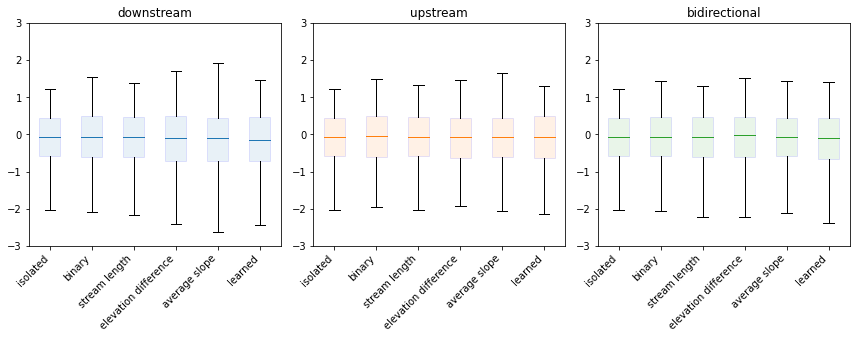

In [81]:
plt.figure(figsize=(12, 4.8))
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for i, edge_dir in enumerate(eigvals.keys()):
    plt.subplot(1, 3, i + 1)
    plt.title(edge_dir)
    keys = ["isolated", "binary", "stream_length", "elevation_difference", "average_slope", "learned"]
    plt.boxplot([eigvals[edge_dir][k] for k in keys], labels=[k.replace("_", " ") for k in keys], whis=10, 
                patch_artist=True, medianprops=dict(color=colors[i]), boxprops=dict(facecolor=colors[i], color="b", alpha=0.1))
    plt.xticks(rotation=45, ha="right")
    plt.ylim((-3, 3))
plt.tight_layout()
plt.savefig("graffnn_eigvals.pdf")
plt.show()